# Import Modules

In [1]:
import pandas as pd
import numpy as np
from math import inf

import statsmodels.api as sm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

import scipy.stats as stats

from statsmodels.stats.outliers_influence import summary_table

# Load Datasets

In [2]:
world_dataset = pd.read_csv("../../../../data/stage_II/owid-covid-data.csv")
super_dataset = pd.read_csv("../../../../data/stage_I/superDataset.csv")
hospital_dataset = pd.read_csv("../../../../data/stage_I/Definitive_Healthcare _USA_Hospital_Beds.csv")
state_data = super_dataset[super_dataset.State == "NC"]
state_hospitals = hospital_dataset[hospital_dataset.HQ_STATE == "NC"]
# Sort data by second last column values (last column for cumulative cases)
state_data = state_data.sort_values(state_data.columns[-2], ascending=False)
state_data.head()

,countyFIPS,County Name,State,StateFIPS,population,2020-01-22_cases,2020-01-22_deaths,2020-01-23_cases,2020-01-23_deaths,2020-01-24_cases,...,2021-03-13_cases,2021-03-13_deaths,2021-03-14_cases,2021-03-14_deaths,2021-03-15_cases,2021-03-15_deaths,2021-03-16_cases,2021-03-16_deaths,2021-03-17_cases,2021-03-17_deaths
1983,37119,Mecklenburg County,NC,37,1110356,0,0,0,0,0,...,98869,891,98869,891,99328,892,99466,892,99683,897
2015,37183,Wake County,NC,37,1111761,0,0,0,0,0,...,76660,566,76660,566,77171,574,77273,574,77516,576
1964,37081,Guilford County,NC,37,537174,0,0,0,0,0,...,40936,564,40936,564,41168,567,41221,567,41320,571
1957,37067,Forsyth County,NC,37,382295,0,0,0,0,0,...,32495,357,32495,357,32651,357,32683,357,32728,357
1949,37051,Cumberland County,NC,37,335509,0,0,0,0,0,...,24791,284,24791,284,24917,284,24974,284,25034,287


# Get new cases and deaths dataframe

1. Extract cases columns from super dataset and save as a new dataframe
2. To find the first day of new cases in NC:
    - Get all columns where there is at least 1 non-zero value along columns
    - Get the column name of the first column returned
    - Use only the columns after the column found above
3. Perform the same operation for new deaths in NC
4. Find difference between consecutive dates using diff()
5. Replace first column values in diff() with original column values

In [75]:
# Extract cases from nc_data
cases_data = state_data[(i for i in state_data.columns if "_cases" in i)]
# Rename columns: remove '_cases' from column names (if present)
cases_data.columns = [i.replace("_cases", "") for i in cases_data.columns]
# Only use columns after the first day of cases registered in NC
cases_data = cases_data.loc[:, cases_data.columns[(cases_data != 0).any()][0]:]
new_cases = pd.concat([cases_data.iloc[:,:1], cases_data.diff(axis=1).iloc[:, 1:]], axis=1)

# Extract cases from nc_data
deaths_data = state_data[(i for i in state_data.columns if "_deaths" in i)]
# Rename columns: remove '_cases' from column names (if present)
deaths_data.columns = [i.replace("_deaths", "") for i in deaths_data.columns]
# Only use columns after the first day of cases registered in NC
deaths_data = deaths_data.loc[:, deaths_data.columns[(deaths_data != 0).any()][0]:]
new_deaths = pd.concat([deaths_data.iloc[:,:1], deaths_data.diff(axis=1).iloc[:, 1:]], axis=1)

# Fit model and make prediction (Linear Regression)

In [106]:
predict_days = 90
cases = pd.DataFrame(new_cases.sum(axis=0)).reset_index()
deaths = pd.DataFrame(new_deaths.sum(axis=0)).reset_index()
cases['days'] = np.arange(1, cases.shape[0]+1)
deaths['days'] = np.arange(1, deaths.shape[0]+1)
cases.columns = ['date', 'cases', 'days']
deaths.columns = ['date', 'deaths', 'days']
cases = cases[['date', 'days', 'cases']]
deaths = deaths[['date', 'days', 'deaths']]
lr_model_cases = sm.OLS(cases.cases, cases.days).fit()
lr_model_deaths = sm.OLS(deaths.deaths, deaths.days).fit()
temp = pd.DataFrame({"days": cases.days.values[-1] + np.arange(predict_days), "cases": np.ceil(lr_model_cases.predict(days))})
temp = pd.concat([cases, temp])
lr_model_cases = sm.OLS(temp.cases, temp.days).fit()
temp = pd.DataFrame({"days": deaths.days.values[-1] + np.arange(predict_days), "deaths": np.ceil(lr_model_deaths.predict(days))})
temp = pd.concat([deaths, temp])
lr_model_deaths = sm.OLS(temp.deaths, temp.days).fit()
st, data, ss2 = summary_table(lr_model_cases, alpha=0.05)
data = pd.DataFrame.from_records(data, columns=[s.replace('\n', ' ') for s in ss2])
data.rename(columns={"Obs": "days", "Predicted Value": "pred"}, inplace=True)
cases = pd.concat([data, cases['cases']], axis=1)
st, data, ss2 = summary_table(lr_model_deaths, alpha=0.05)
data = pd.DataFrame.from_records(data, columns=[s.replace('\n', ' ') for s in ss2])
data.rename(columns={"Obs": "days", "Predicted Value": "pred"}, inplace=True)
deaths = pd.concat([data, deaths['deaths']], axis=1)

# Visualization

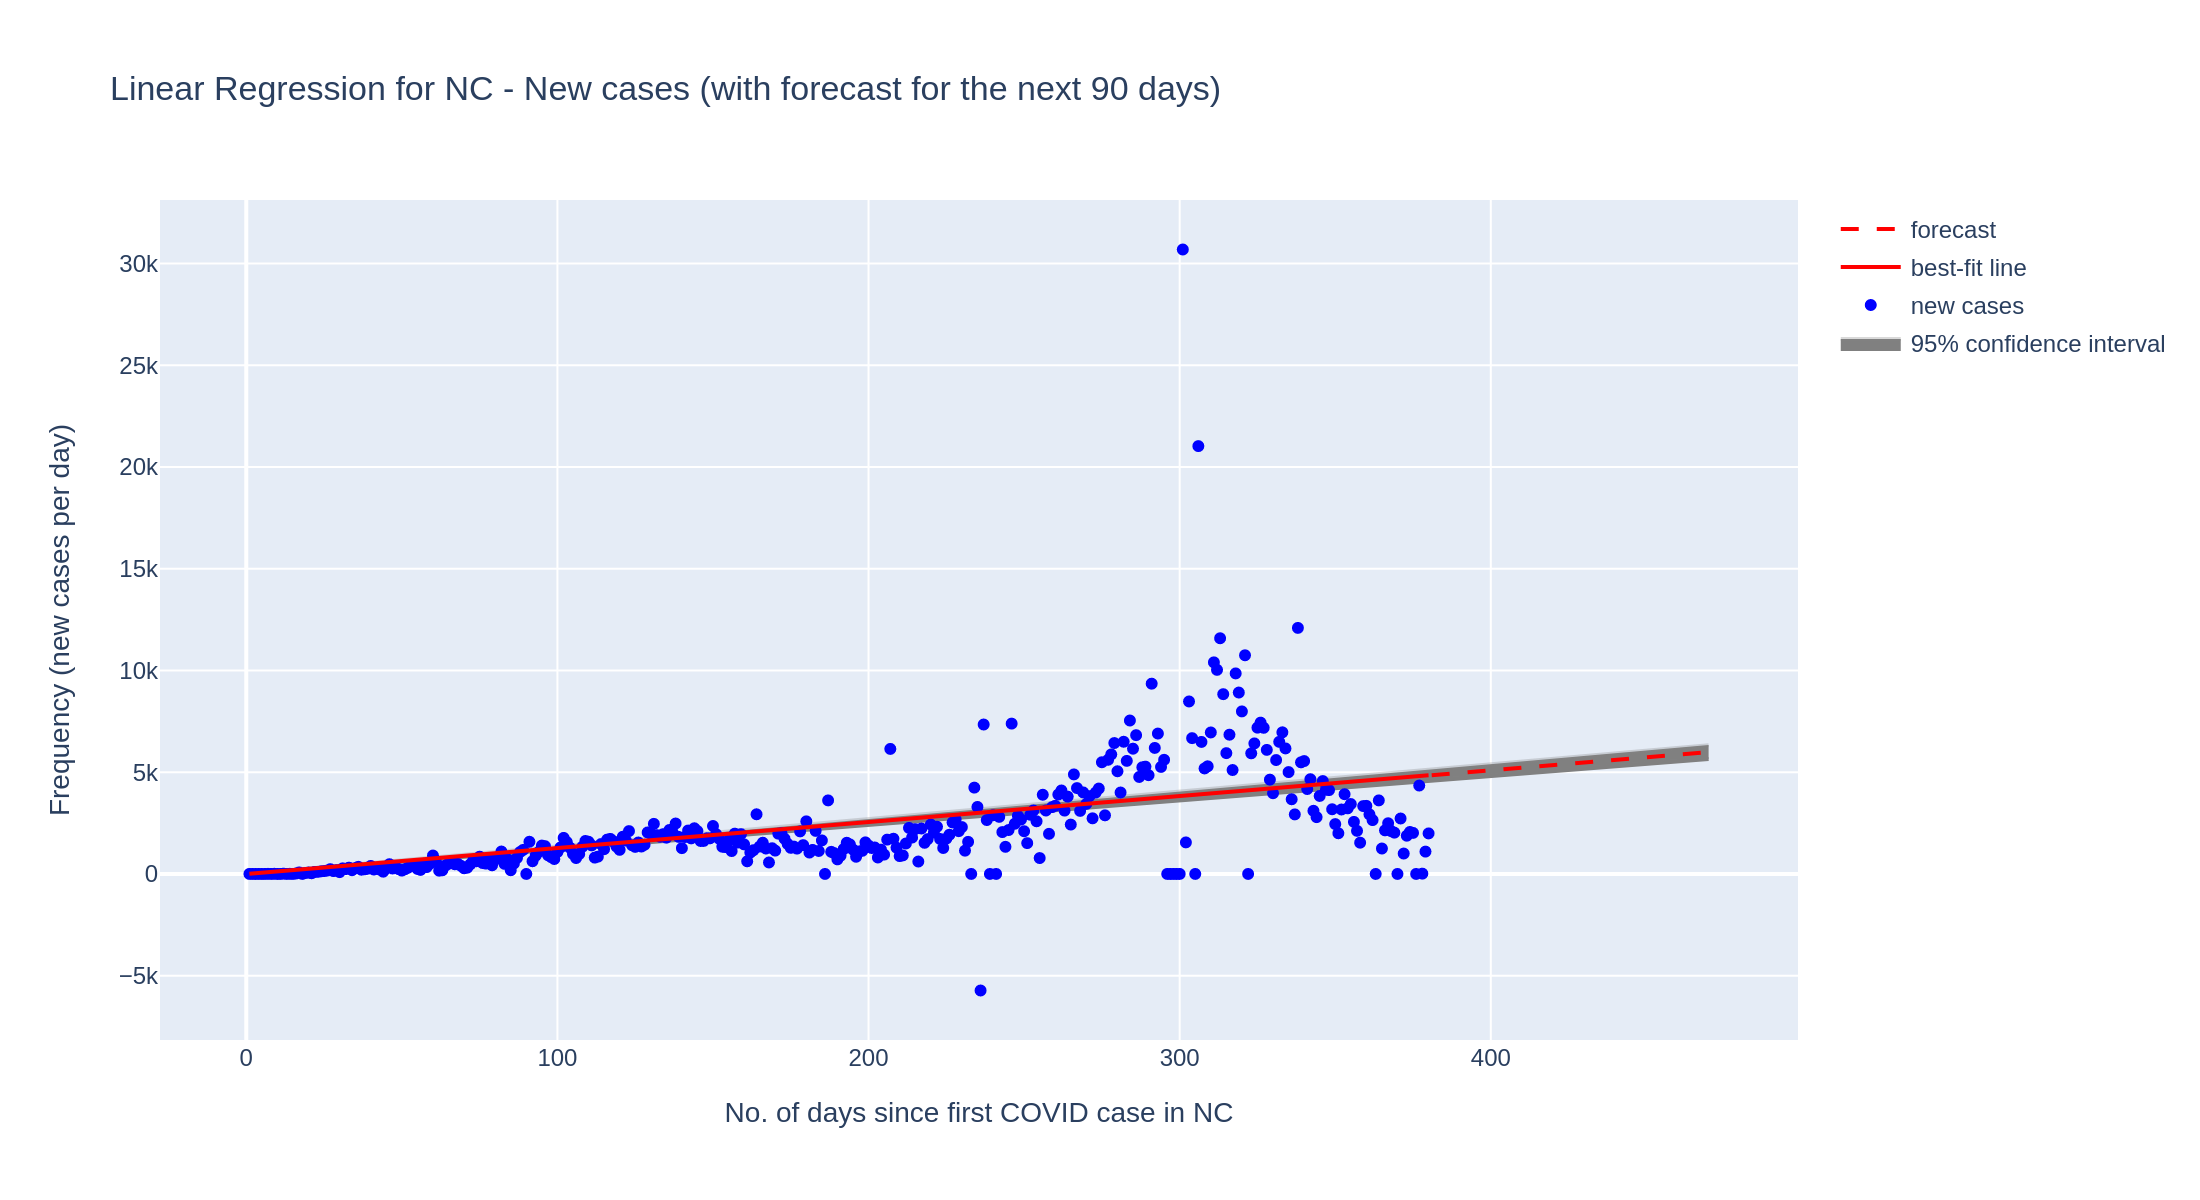

In [107]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=cases['days'], y=cases['Mean ci 95% low'], showlegend=False, line=dict(color='grey'))
)
fig.add_trace(
    go.Scatter(x=cases['days'], y=cases['Mean ci 95% upp'], fill='tonexty', line=dict(color='rgba(128, 128, 128, 0.3)'), fillcolor='grey', name='95% confidence interval')
)
fig.add_trace(
    go.Scatter(x=cases['days'], y=cases['cases'], mode='markers', name='new cases', marker=dict(color='blue')),
)

fig.add_trace(
    go.Scatter(x=cases[:-predict_days]['days'], y=cases[:-predict_days]['pred'], mode='lines', marker=dict(size=10), name='best-fit line',
              line=dict(color='red'))
)
fig.add_trace(
    go.Scatter(x=cases[-predict_days:]['days'], y=cases[-predict_days:]['pred'], mode='lines', marker=dict(size=10), name='forecast', line=dict(dash='dash', color='red'))
)
fig.update_layout(
    title="Linear Regression for NC - New cases (with forecast for the next 90 days)",
    xaxis_title="No. of days since first COVID case in NC",
    yaxis_title="Frequency (new cases per day)",
)
img_bytes = fig.to_image(format="png", width=1100, height=600, scale=2)
Image(img_bytes)

I extrapolated the line of best fit in order to make the prediction path more visible.

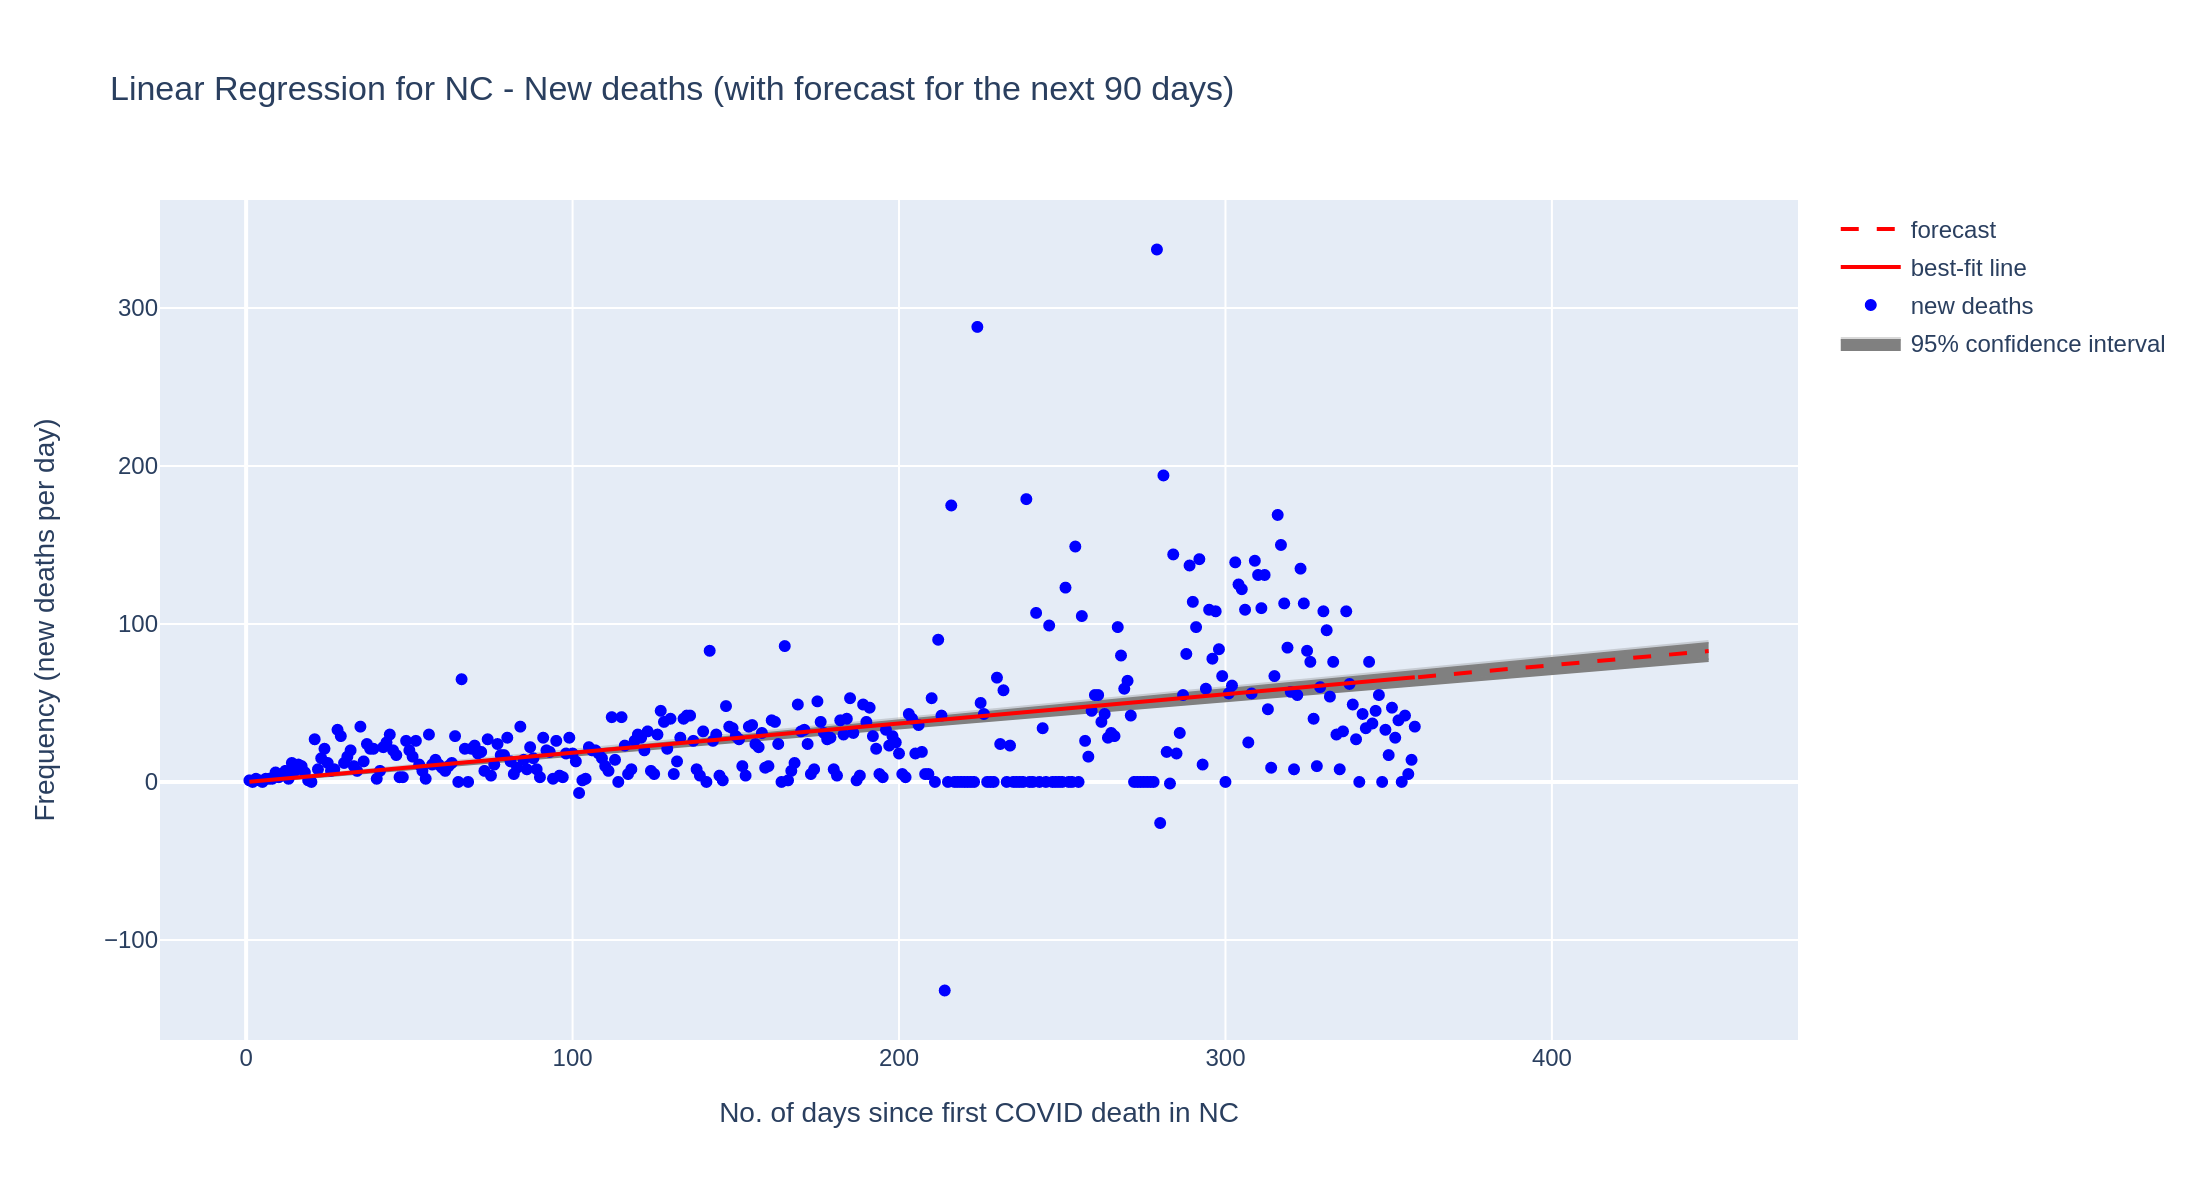

In [109]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=deaths['days'], y=deaths['Mean ci 95% low'], showlegend=False, line=dict(color='grey'))
)
fig.add_trace(
    go.Scatter(x=deaths['days'], y=deaths['Mean ci 95% upp'], fill='tonexty', line=dict(color='rgba(128, 128, 128, 0.3)'), fillcolor='grey', name='95% confidence interval')
)
fig.add_trace(
    go.Scatter(x=deaths['days'], y=deaths['deaths'], mode='markers', name='new deaths', marker=dict(color='blue')),
)

fig.add_trace(
    go.Scatter(x=deaths[:-predict_days]['days'], y=deaths[:-predict_days]['pred'], mode='lines', marker=dict(size=10), name='best-fit line',
              line=dict(color='red'))
)
fig.add_trace(
    go.Scatter(x=deaths[-predict_days:]['days'], y=deaths[-predict_days:]['pred'], mode='lines', marker=dict(size=10), name='forecast', line=dict(dash='dash', color='red'))
)
fig.update_layout(
    title="Linear Regression for NC - New deaths (with forecast for the next 90 days)",
    xaxis_title="No. of days since first COVID death in NC",
    yaxis_title="Frequency (new deaths per day)",
)
img_bytes = fig.to_image(format="png", width=1100, height=600, scale=2)
Image(img_bytes)

## Root Mean Square Error (RMSE)

### RMSE error for cases prediction

In [112]:
np.sqrt(mean_squared_error(cases[:-predict_days].cases, cases[:-predict_days].pred))

2433.9479109665594

### RMSE error for deaths prediction

In [114]:
np.sqrt(mean_squared_error(deaths[:-predict_days].deaths, deaths[:-predict_days].pred))

39.584752119125646

# Fit model and make prediction (Polynomial Regression)

In [131]:
cases = pd.DataFrame(new_cases.sum(axis=0)).reset_index()
deaths = pd.DataFrame(new_deaths.sum(axis=0)).reset_index()
cases['days'] = np.arange(1, cases.shape[0]+1)
deaths['days'] = np.arange(1, deaths.shape[0]+1)
cases.columns = ['date', 'cases', 'days']
deaths.columns = ['date', 'deaths', 'days']
cases = cases[['date', 'days', 'cases']]
deaths = deaths[['date', 'days', 'deaths']]

polynomial_features_cases = PolynomialFeatures(degree=8)
y = cases.cases
xp = polynomial_features_cases.fit_transform(cases.days.values.reshape(cases.days.shape[0], 1))
poly_model_cases = sm.OLS(y.values.reshape(y.shape[0], 1), xp).fit()
cases['poly_pred'] = np.ceil(poly_model_cases.predict(xp))

# Visualization

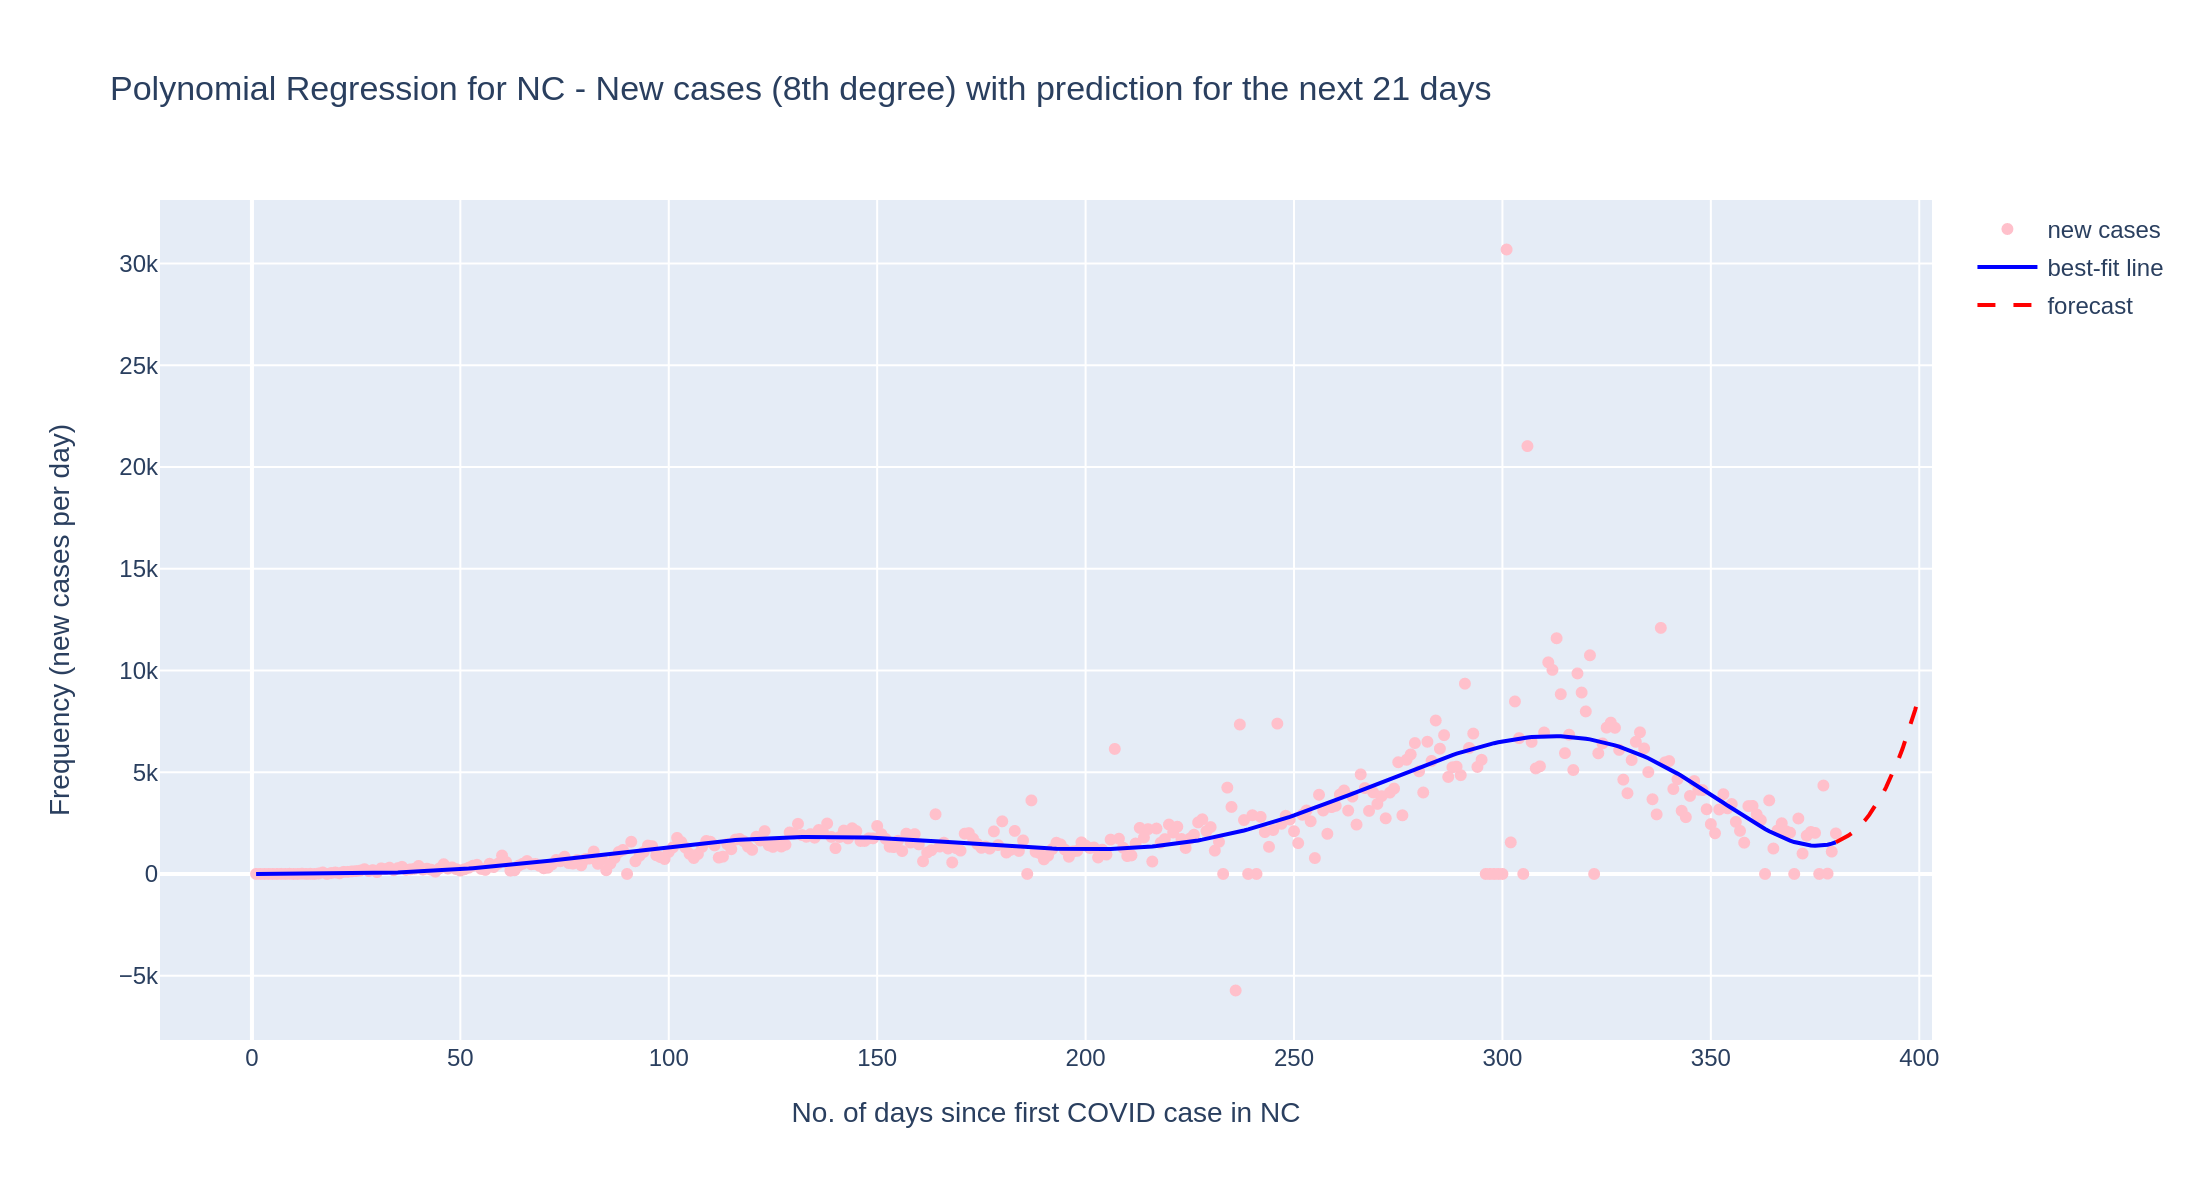

In [132]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=cases['days'], y=cases['cases'], mode='markers', name='new cases', marker=dict(color='pink')),
)
fig.add_trace(
    go.Scatter(x=cases['days'], y=cases['poly_pred'], mode='lines', marker=dict(size=10), name='best-fit line',
              line=dict(color='blue'))
)
days = cases.days.values[-1] + np.arange(21)
xp = polynomial_features_cases.fit_transform(days.reshape(days.shape[0], 1))
preds = np.ceil(poly_model_cases.predict(xp))
fig.add_trace(
    go.Scatter(x=days, y=preds, mode='lines', marker=dict(size=10), name='forecast', line=dict(dash='dash', color='red'))
)
fig.update_layout(
    title="Polynomial Regression for NC - New cases (8th degree) with prediction for the next 21 days",
    xaxis_title="No. of days since first COVID case in NC",
    yaxis_title="Frequency (new cases per day)",
)
img_bytes = fig.to_image(format="png", width=1100, height=600, scale=2)
Image(img_bytes)

## Root Mean Square Error (RMSE)

### RMSE error for cases prediction

In [133]:
np.sqrt(mean_squared_error(cases.cases, cases.poly_pred))

2030.666186384733

From the above graph, we can observe that there are some outliers that have significantly affected the RMSE value. To check how the model is performing for values other than the two outliers, we can ignore the outlier values and calculate RMSE again.

In [134]:
temp = cases.drop(cases.cases.nlargest(2).index, axis=0)
np.sqrt(mean_squared_error(temp.cases, temp.poly_pred))

1436.1462238193144

In [135]:
polynomial_features_deaths = PolynomialFeatures(degree=4)
y = deaths.deaths
xp = polynomial_features_deaths.fit_transform(deaths.days.values.reshape(deaths.days.shape[0], 1))
poly_model_deaths = sm.OLS(y.values.reshape(y.shape[0], 1), xp).fit()
deaths['poly_pred'] = np.ceil(poly_model_deaths.predict(xp))

### RMSE error for deaths prediction

In [136]:
np.sqrt(mean_squared_error(deaths.deaths, deaths.poly_pred))

38.165217133964816

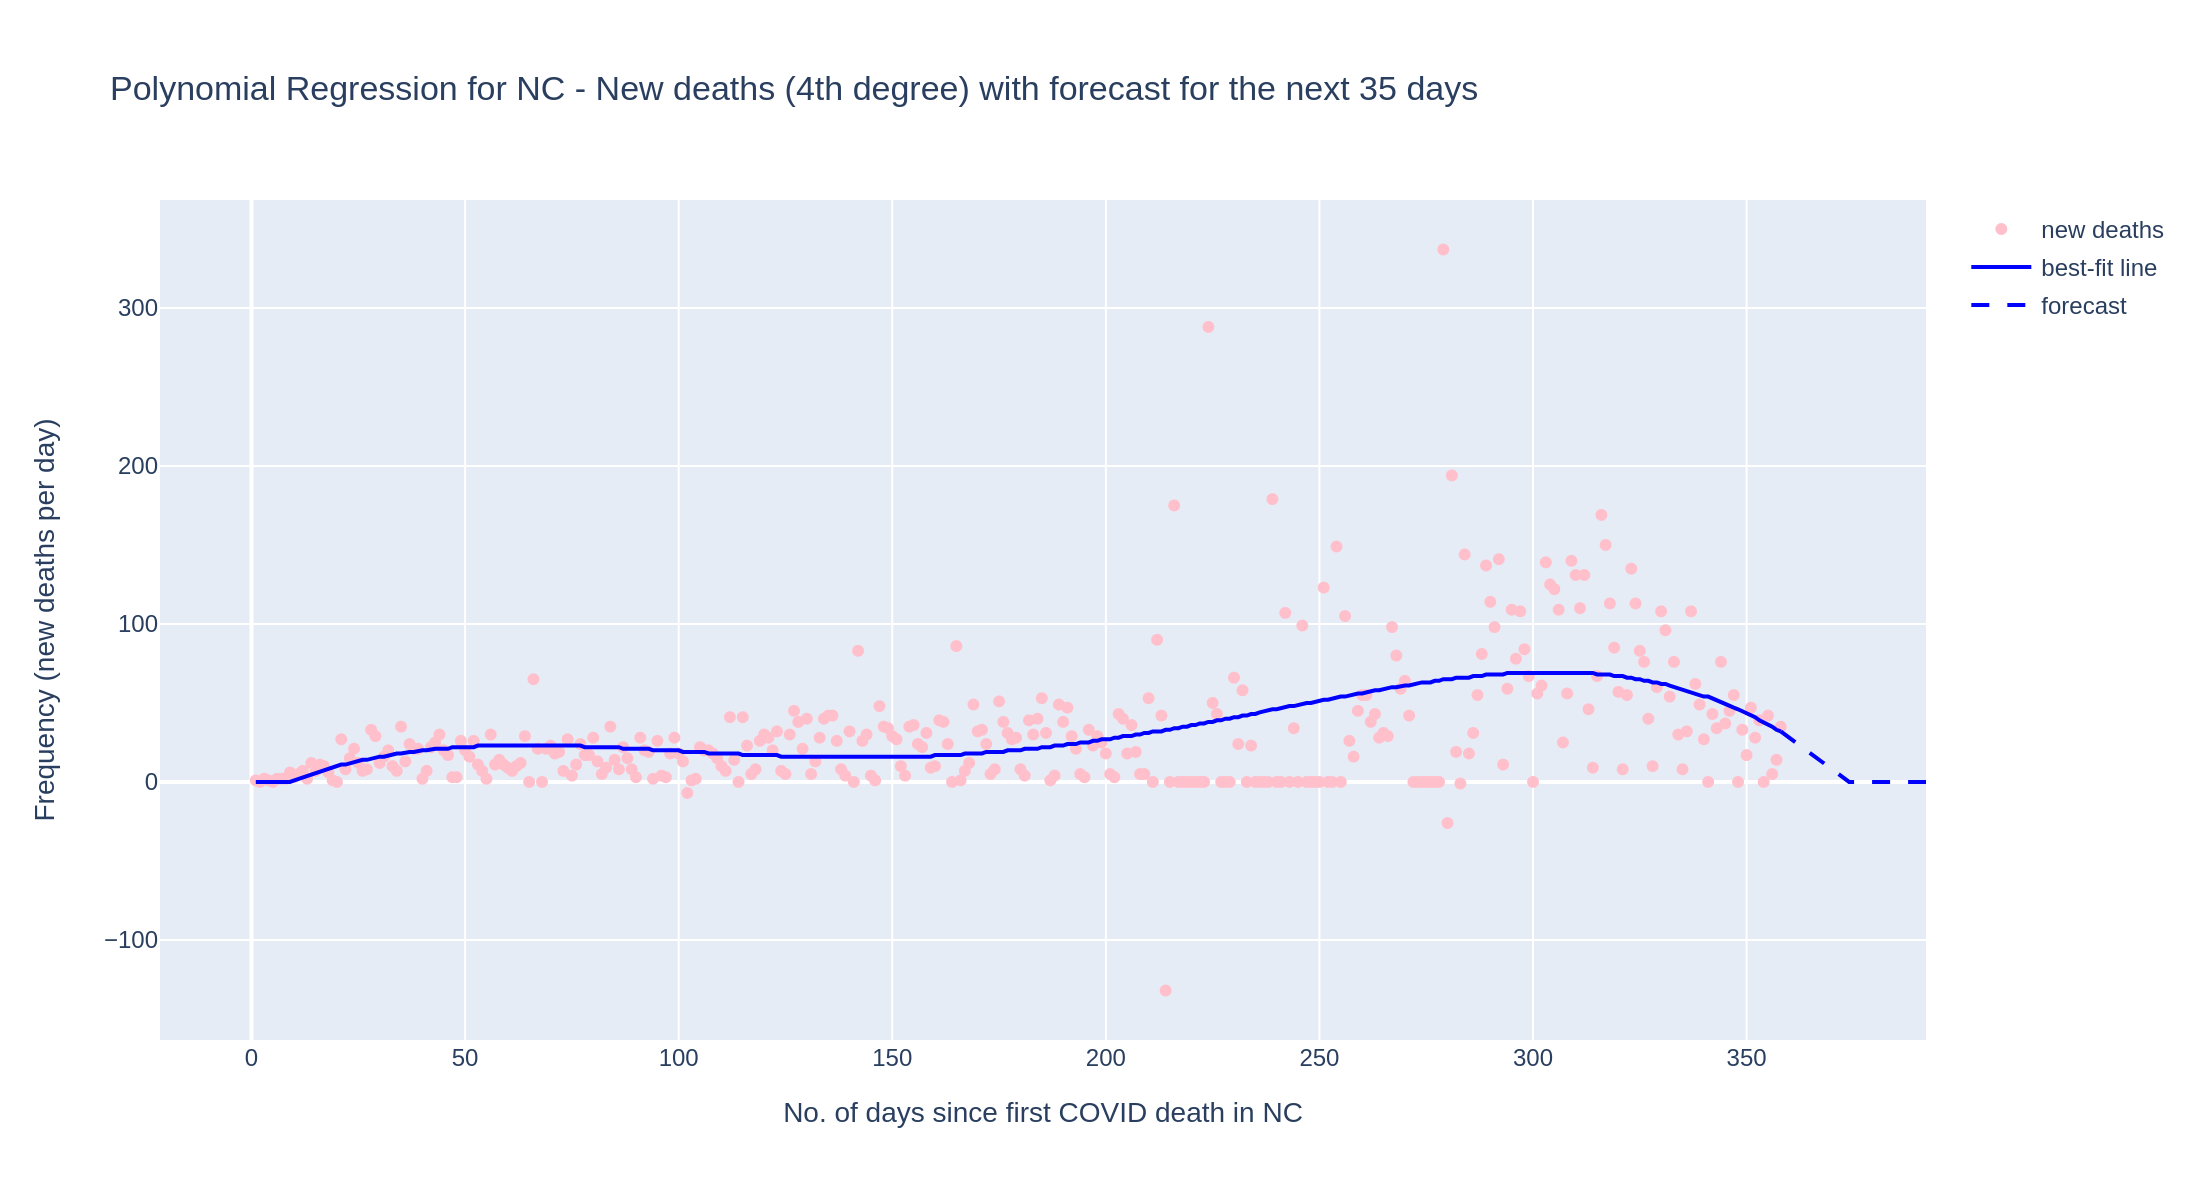

In [137]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=deaths['days'], y=deaths['deaths'], mode='markers', name='new deaths', marker=dict(color='pink')),
)
fig.add_trace(
    go.Scatter(x=deaths['days'], y=[i if i >0 else 0 for i in deaths['poly_pred']], mode='lines', marker=dict(size=10), name='best-fit line',
              line=dict(color='blue'))
)
days = deaths.days.values[-1] + np.arange(35)
xp = polynomial_features_deaths.fit_transform(days.reshape(days.shape[0], 1))
# Because deaths cannot be negative, convert all negative values to 0
preds = [i if i > 0 else 0 for i in np.ceil(poly_model_deaths.predict(xp))]
fig.add_trace(
    go.Scatter(x=days, y=preds, mode='lines', marker=dict(size=10), name='forecast', line=dict(dash='dash', color='blue'))
)
fig.update_layout(
    title="Polynomial Regression for NC - New deaths (4th degree) with forecast for the next 35 days",
    xaxis_title="No. of days since first COVID death in NC",
    yaxis_title="Frequency (new deaths per day)",
)
img_bytes = fig.to_image(format="png", width=1100, height=600, scale=2)
Image(img_bytes)

In [138]:
def check_rmse(pd_df):
    temp = pd_df.copy()
    rmse = inf
    req = 0
    for i in range(20):
        polynomial_features = PolynomialFeatures(degree=i)
        y = temp.cases
        xp = polynomial_features.fit_transform(temp.days.values.reshape(temp.days.shape[0], 1))
        pm = sm.OLS(y.values.reshape(y.shape[0], 1), xp).fit()
        temp['poly_pred'] = np.ceil(pm.predict(xp))
        temp_rmse = np.sqrt(mean_squared_error(temp.cases, temp.poly_pred))
        if temp_rmse < rmse:
            rmse = temp_rmse
            req = i
    return req

In [153]:
def poly_fit(new_cases, county_id, county_popn, color, days):
    go_objs = []
    county_cases = np.ceil(new_cases.loc[[county_id]].T/county_popn * max_popn)
    county_cases = county_cases[county_cases[county_cases[county_id] != 0].index[0]:]
    county_cases.columns = ['cases']
    county_cases['days'] = np.arange(1, county_cases.shape[0]+1)
    lr_model_cases = sm.OLS(county_cases.cases, county_cases.days).fit()
    county_cases['lr_pred'] = np.ceil(lr_model_cases.predict(county_cases.days))
    degree = check_rmse(county_cases)
    polynomial_features_cases = PolynomialFeatures(degree=degree)
    y = county_cases.cases
    xp = polynomial_features_cases.fit_transform(county_cases.days.values.reshape(county_cases.days.shape[0], 1))
    poly_model_cases = sm.OLS(y.values.reshape(y.shape[0], 1), xp).fit()
    county_cases['poly_pred'] = np.ceil(poly_model_cases.predict(xp))
    go_objs.append(go.Scatter(x=county_cases['days'], y=county_cases['cases'], mode='markers', name='new cases', marker=dict(color='pink')))
    go_objs.append(go.Scatter(x=county_cases['days'], y=county_cases['poly_pred'], mode='lines', marker=dict(size=10), name=state_data.loc[i]['County Name'].split(" ")[0], 
                              line=dict(color=color)))
    go_objs.append(go.Scatter(x=county_cases['days'], y=county_cases['lr_pred'], mode='lines', marker=dict(size=10), name='best-fit line',
              line=dict(color='black')))
#     days = cases.days.values[-1] + np.arange(14)
#     xp = polynomial_features_cases.fit_transform(days.reshape(days.shape[0], 1))
#     preds = np.ceil(poly_model_cases.predict(xp))
#     go_objs.append(go.Scatter(x=days, y=preds, mode='lines', marker=dict(size=10), name='forecast', line=dict(dash='dash', color='red')))
    return county_cases, go_objs, poly_model_cases, degree

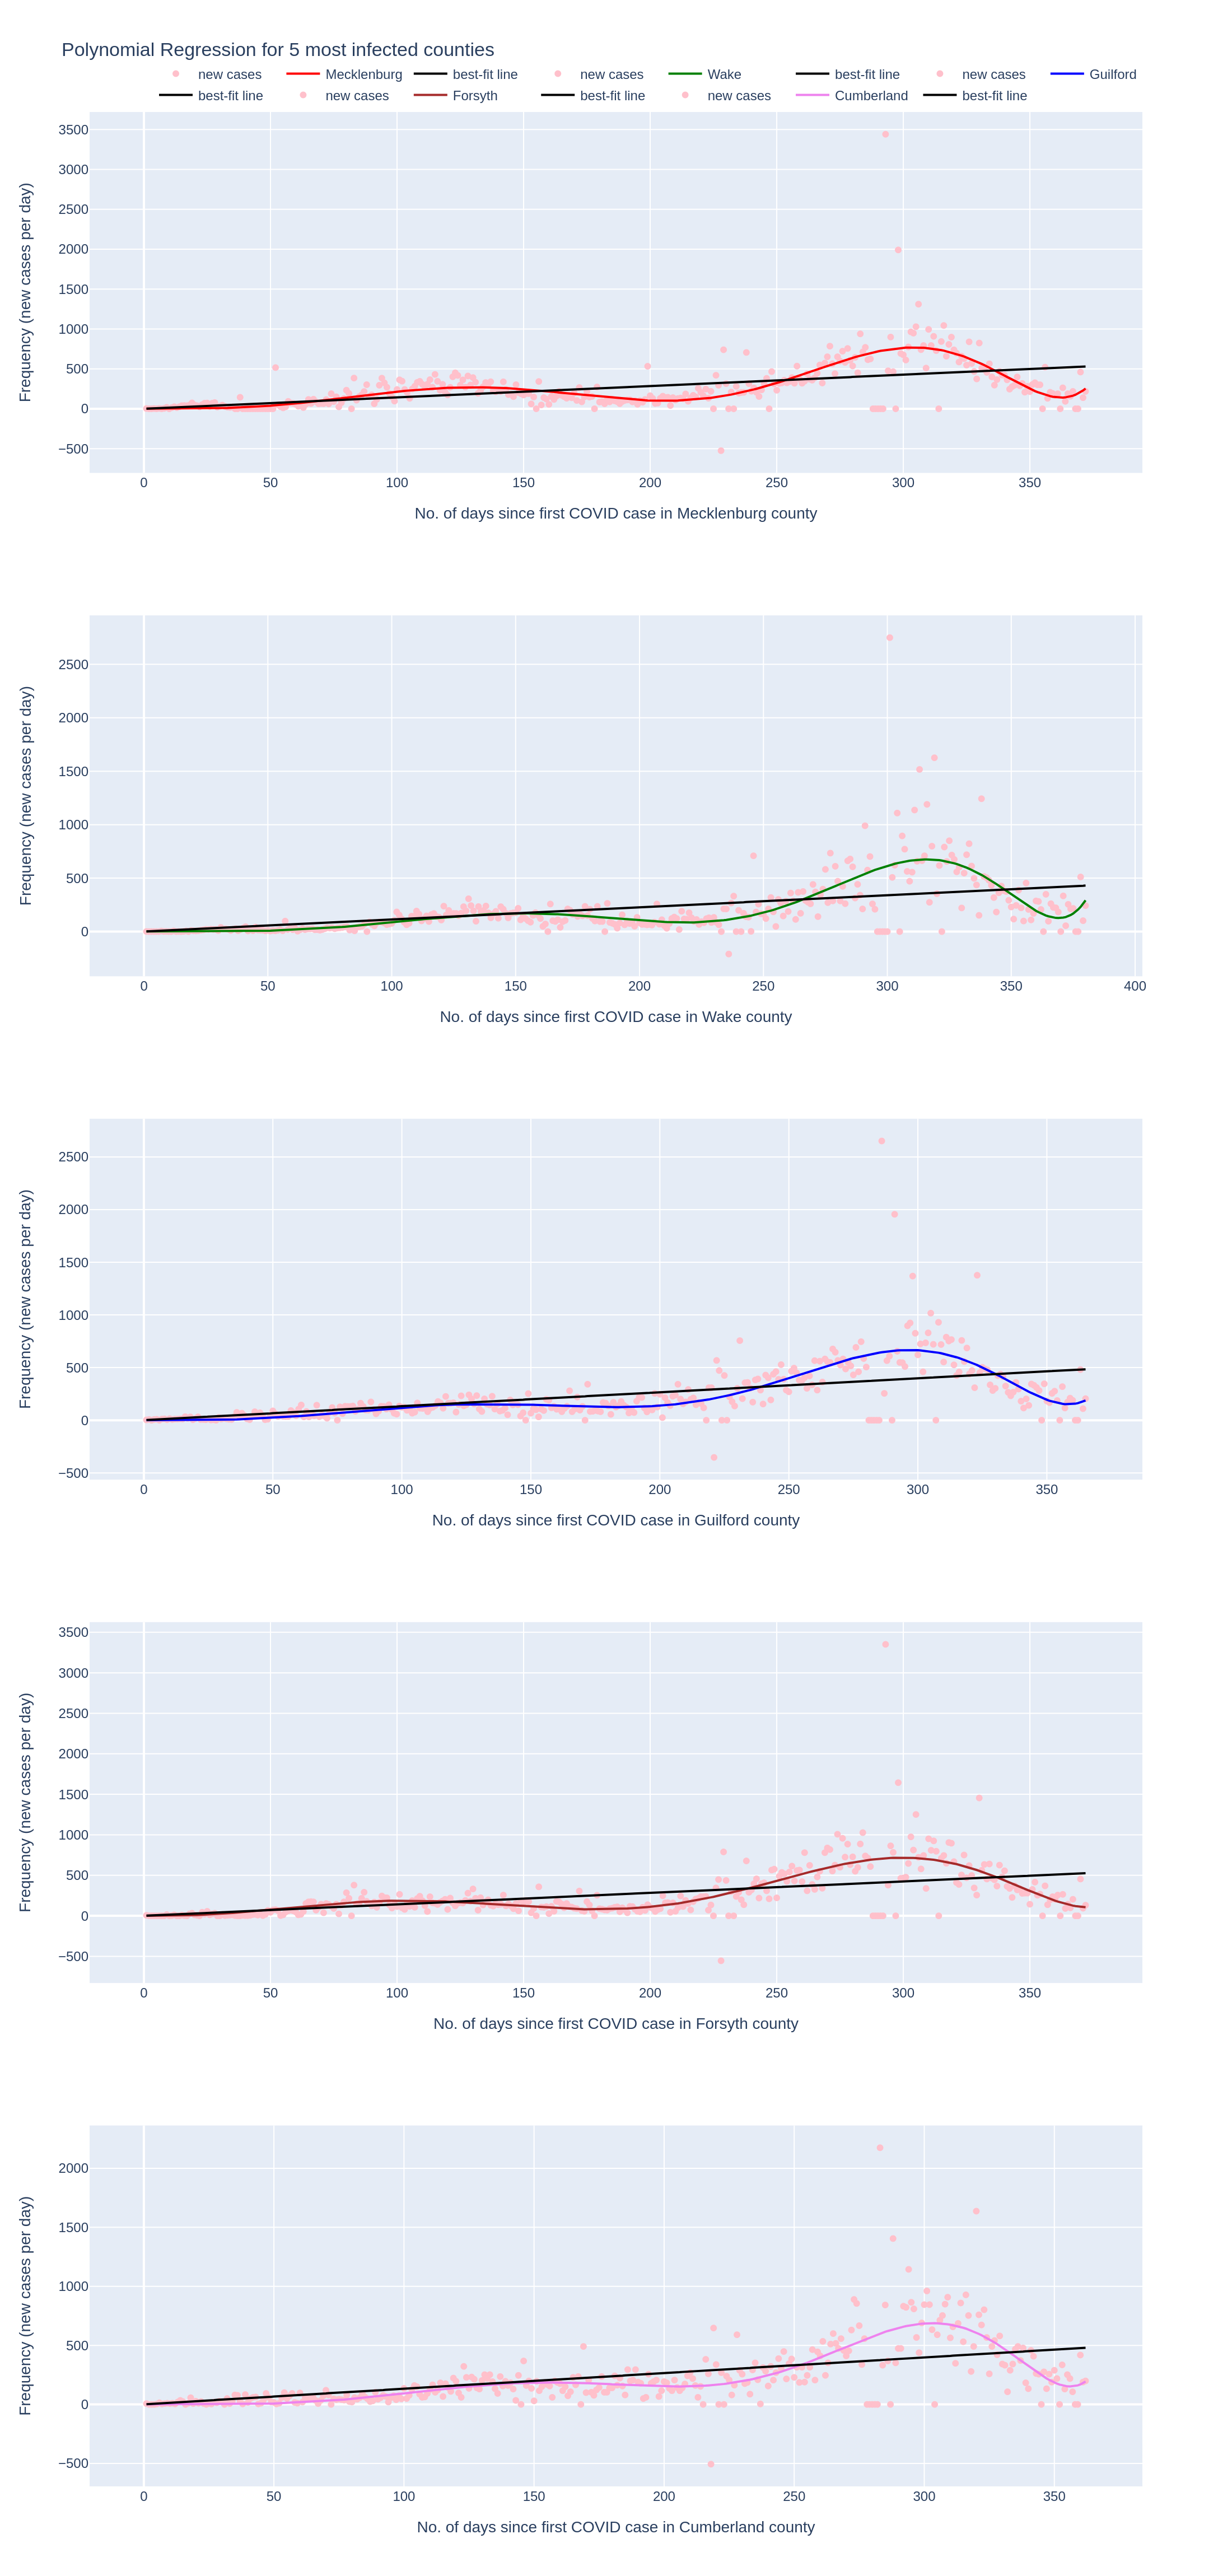

In [154]:
fig = make_subplots(rows=5, cols=1)
max_popn = state_data.population.max()
colors = ['red', 'green', 'blue', 'brown', 'violet']
county_dfs = []
models = []
for idx, i in enumerate(cases_data.index[:5]):
    county_name = state_data.loc[i]['County Name'].split(" ")[0]
    popn = state_data.loc[i].population
    county_cases, go_objs, model, degree = poly_fit(new_cases, i, popn, colors[idx], days)
    county_dfs.append(county_cases)
    models.append((model, degree))
    for go_obj in go_objs:
        fig.append_trace(go_obj, idx+1, col=1)
    fig.update_xaxes(title_text="No. of days since first COVID case in {0} county".format(county_name), row=idx+1, col=1)
    fig.update_yaxes(title_text="Frequency (new cases per day)", row=idx+1, col=1)
fig.update_layout(
    title="Polynomial Regression for 5 most infected counties",
    legend=dict(orientation="h", yanchor="top", y=1.023, xanchor="right", x=1)
)
img_bytes = fig.to_image(format="png", width=1100, height=2300, scale=2)
Image(img_bytes)

### RMSE for cases across 5 counties

In [141]:
for idx, i in enumerate(cases_data.index[:5]):
    temp = county_dfs[idx]
    county_name = state_data.loc[i]['County Name'].split(" ")[0]
    print("Linear Regression RMSE for cases in {0} county: {1:.2f}\nPolynomial Regression RMSE for cases in {0} county: {2:.2f}".format(
        county_name, np.sqrt(mean_squared_error(temp.lr_pred, temp.cases)),
        np.sqrt(mean_squared_error(temp.poly_pred, temp.cases)),
    ))

Linear Regression RMSE for cases in Mecklenburg county: 268.94
Polynomial Regression RMSE for cases in Mecklenburg county: 216.40
Linear Regression RMSE for cases in Wake county: 233.65
Polynomial Regression RMSE for cases in Wake county: 190.51
Linear Regression RMSE for cases in Guilford county: 230.46
Polynomial Regression RMSE for cases in Guilford county: 190.08
Linear Regression RMSE for cases in Forsyth county: 266.28
Polynomial Regression RMSE for cases in Forsyth county: 215.89
Linear Regression RMSE for cases in Cumberland county: 216.88
Polynomial Regression RMSE for cases in Cumberland county: 176.65


# Visualizing trends for top 5 infected counties

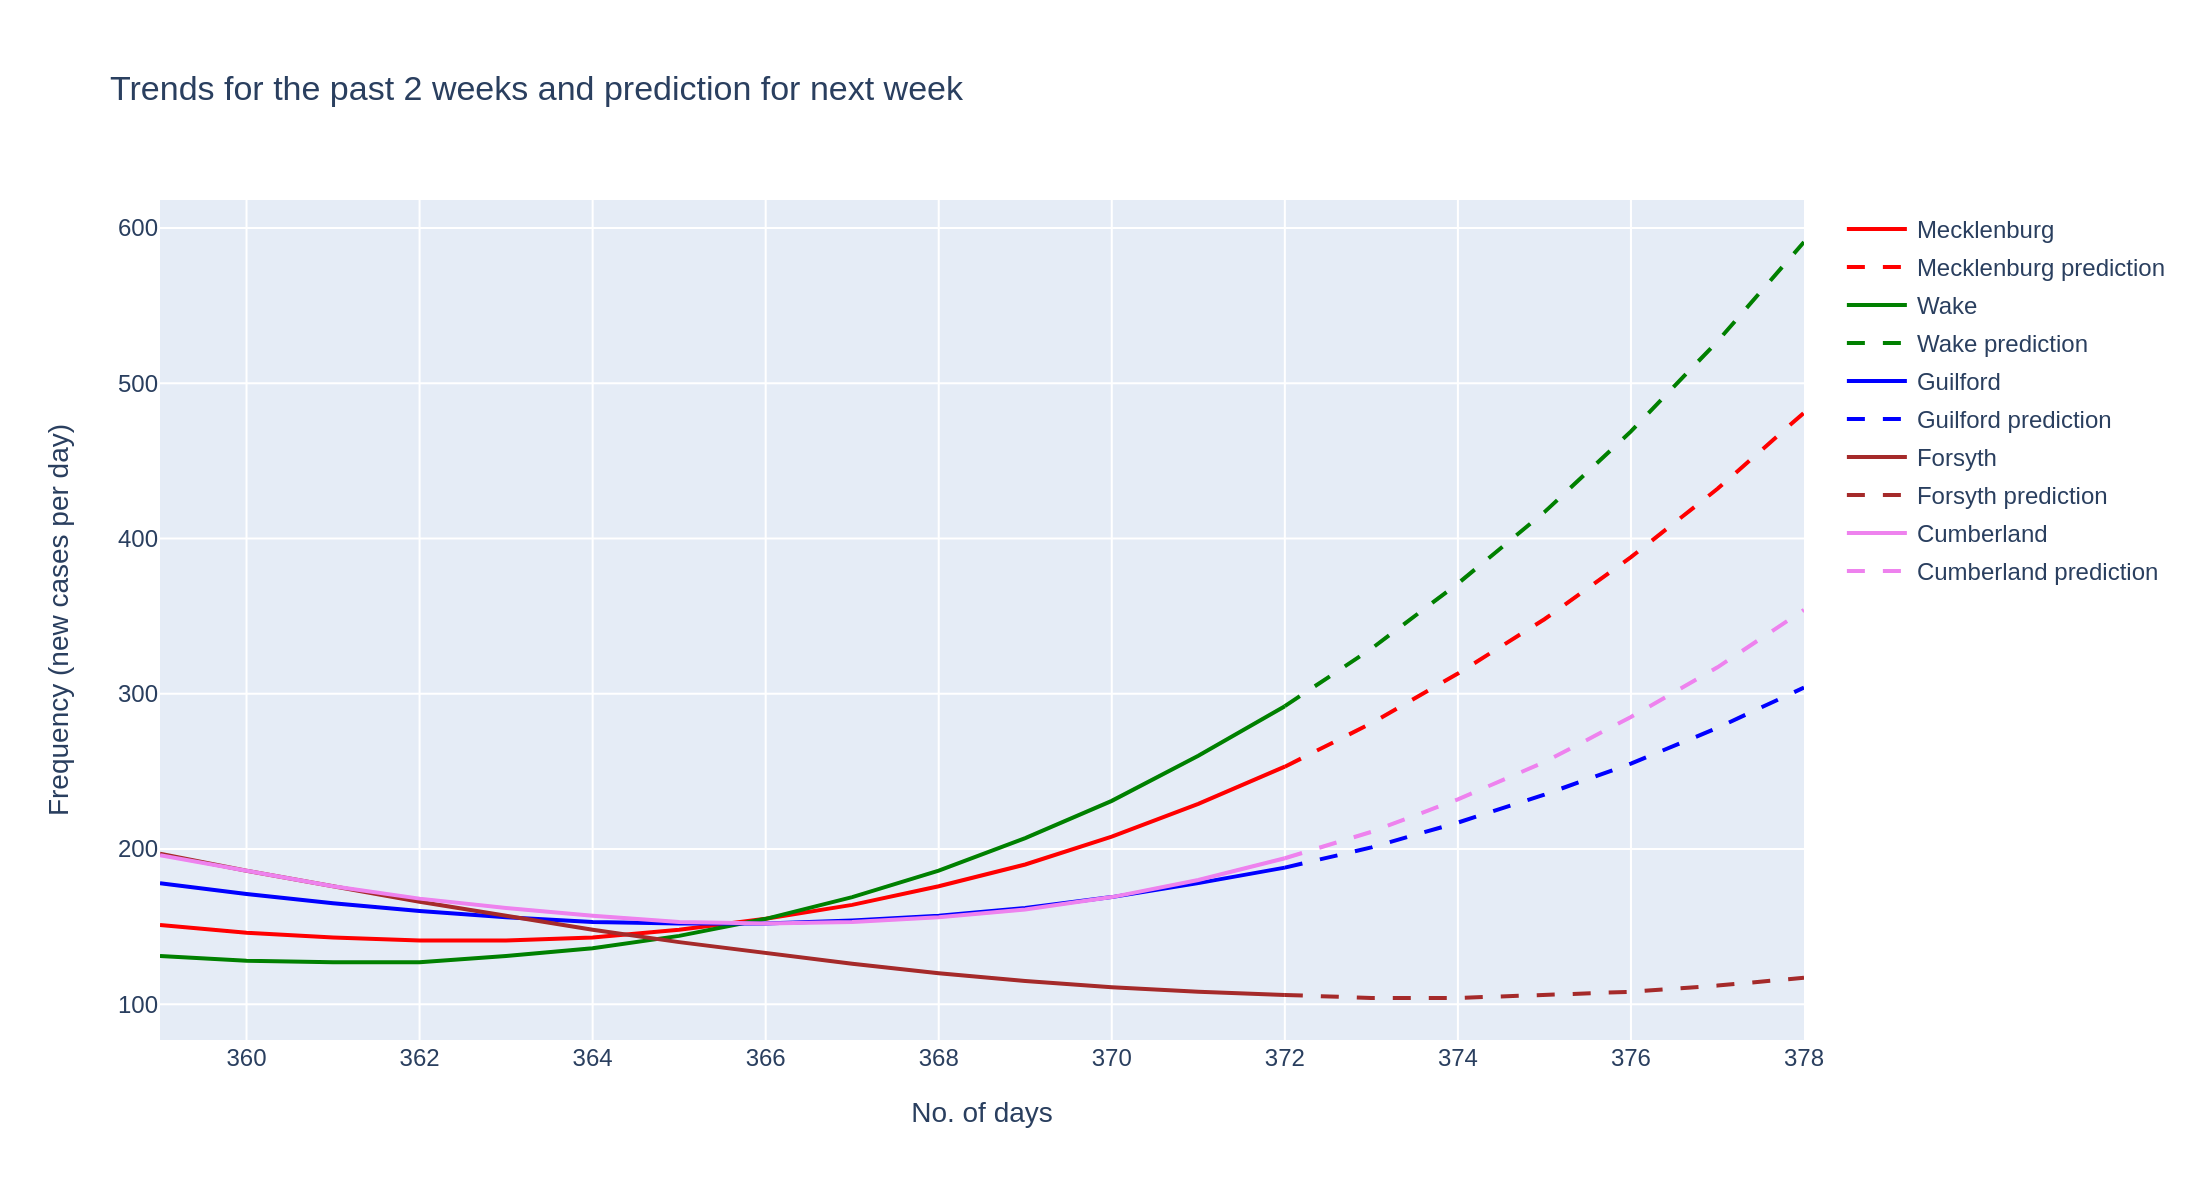

In [142]:
fig = go.Figure()
for idx, i in enumerate(cases_data.index[:5]):
    lr_model, degree = models[idx][0], models[idx][1]
    county_name = state_data.loc[i]['County Name'].split(" ")[0]
    xp = PolynomialFeatures(degree=degree).fit_transform((county_dfs[idx].days[-2] + 1 + np.arange(7)).reshape(7,1))
    preds = county_dfs[idx][-14:].poly_pred.values
#     preds = np.concatenate((county_dfs[idx][-14:].poly_pred.values, np.ceil(lr_model.predict(xp))), axis=None)
#     days = county_dfs[0].days[-20] + np.arange(27)
    days = county_dfs[0].days[-14:]
    fig.add_trace(
        go.Scatter(x=days, y=preds, mode='lines', marker=dict(size=10), name='{0}'.format(county_name), line=dict(color=colors[idx]))
    )
    preds = np.ceil(lr_model.predict(xp))
#     preds = np.concatenate((county_dfs[idx][-14:].poly_pred.values, np.ceil(lr_model.predict(xp))), axis=None)
#     days = county_dfs[0].days[-20] + np.arange(27)
    days = county_dfs[0].days[-2] + 1 + np.arange(7)
    fig.add_trace(
        go.Scatter(x=days, y=preds, mode='lines', marker=dict(size=10), name='{0} prediction'.format(county_name), line=dict(dash='dash', color=colors[idx]))
    )
    
fig.update_layout(
    title="Trends for the past 2 weeks and prediction for next week",
    xaxis_title="No. of days",
    yaxis_title="Frequency (new cases per day)",
)
img_bytes = fig.to_image(format="png", width=1100, height=600, scale=2)
Image(img_bytes)

In [143]:
icu_beds_available = (state_hospitals['NUM_ICU_BEDS']*(1 - state_hospitals['BED_UTILIZATION'])).sum()
deaths_per_case = new_deaths[-100:].sum(axis=0).mean()/ new_cases[-100:].sum(axis=0).mean()
last_date = deaths.days.values[-1]
days = 100
new_dates = deaths.days.values[-1] + np.arange(days)
new_dates = new_dates.reshape(new_dates.shape[0], 1)
xp = polynomial_features_cases.fit_transform(new_dates)
daily_pred = np.ceil(poly_model_cases.predict(xp))
no_return_day = 0
for i in range(days):
    if daily_pred[i]*deaths_per_case > icu_beds_available:
        no_return_day = i
        break
for i in range(1, -1, -1):
    print("Predicted number of new cases after {0} days: {1}".format(no_return_day-i, int(daily_pred[no_return_day-i])))
    print("Number of COVID 19 patients with high health risk:", int(np.ceil(daily_pred[no_return_day-i]*deaths_per_case)))
    print("Number of ICU Beds available per day: {0}\n".format(int(np.floor(icu_beds_available))))

Predicted number of new cases after 71 days: 62630
Number of COVID 19 patients with high health risk: 915
Number of ICU Beds available per day: 918

Predicted number of new cases after 72 days: 66108
Number of COVID 19 patients with high health risk: 966
Number of ICU Beds available per day: 918



If all the other factors affecting the change in number of covid cases per day remains constant and the trend follows, we are likely to observe the point of no return for North Carolina after 71 days or on 72nd day.

# Hypothesis Testing

**Null Hypothesis (H0)**: Higher number of population between 35 and 44 years of age does not contribute in increment of daily covid cases.

**Alternative Hypothesis (H1)**: Higher number of population between 35 and 44 years of age contributes in increment of daily covid cases.

## Two sample, two-tailed t-test

In [144]:
dp5 = pd.read_csv("../../../../data/stage_I/Census_Demographics_ACS/ACSDP5Y2019.DP05_data_with_overlays_2021-02-11T145452.csv", delimiter=",", dtype=object)
dp5['countyFIPS'] = dp5[1:]['GEO_ID'].apply(lambda x: int(x[-5:]))
dp5['countyFIPS'].fillna(0, inplace=True)
dp5.drop(['GEO_ID'], axis = 1, inplace=True)
dp5 = dp5.astype({'countyFIPS': 'int32'})
dp5 = dp5[[dp5.columns[-1]] + list(dp5.columns[:-1])]
dp5.drop(0, inplace=True)
for i in dp5[dp5.columns[2:]]:
    dp5[i] = pd.to_numeric(dp5[i], errors="coerce")
dp5.dropna(axis='columns', how='any', inplace=True)
dp5.head()

,countyFIPS,NAME,DP05_0001E,DP05_0001PE,DP05_0002E,DP05_0002PE,DP05_0003E,DP05_0003PE,DP05_0004E,DP05_0005E,...,DP05_0087M,DP05_0087PE,DP05_0088E,DP05_0088M,DP05_0088PE,DP05_0088PM,DP05_0089E,DP05_0089M,DP05_0089PE,DP05_0089PM
1,1001,"Autauga County, Alabama",55380,55380,26934,48.6,28446,51.4,94.7,3217,...,224,41647,19823,189,47.6,0.2,21824,97,52.4,0.2
2,1003,"Baldwin County, Alabama",212830,212830,103496,48.6,109334,51.4,94.7,11689,...,640,162883,77958,410,47.9,0.2,84925,403,52.1,0.2
3,1005,"Barbour County, Alabama",25361,25361,13421,52.9,11940,47.1,112.4,1349,...,107,19728,10529,80,53.4,0.3,9199,69,46.6,0.3
4,1007,"Bibb County, Alabama",22493,22493,12150,54.0,10343,46.0,117.5,1315,...,87,17662,9469,102,53.6,0.4,8193,43,46.4,0.4
5,1009,"Blount County, Alabama",57681,57681,28495,49.4,29186,50.6,97.6,3432,...,233,42722,20833,182,48.8,0.3,21889,168,51.2,0.3


### Lets consider the data of last 365 days

In [145]:
temp = pd.concat([state_data.iloc[:,:5], new_cases.iloc[:,-365:]], axis=1)
enrichment_df = pd.merge(temp, dp5.drop(dp5.columns[~dp5.columns.isin(['countyFIPS', 'DP05_0011E', 'DP05_0086E', 'DP05_0088E'])], axis=1), on='countyFIPS')
max_popn = enrichment_df.population.max()
temp = enrichment_df.iloc[:,4:].apply(lambda x: np.ceil(x/x['population']*max_popn), axis=1).drop('population', axis=1)
norm_df = pd.concat([enrichment_df.iloc[:,:5], temp], axis=1)
norm_df

,countyFIPS,County Name,State,StateFIPS,population,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,...,2021-03-11,2021-03-12,2021-03-13,2021-03-14,2021-03-15,2021-03-16,2021-03-17,DP05_0011E,DP05_0086E,DP05_0088E
0,37119,Mecklenburg County,NC,37,1110356,5.0,18.0,0.0,14.0,26.0,...,157.0,218.0,0.0,0.0,460.0,139.0,218.0,158962.0,445851.0,337345.0
1,37183,Wake County,NC,37,1111761,2.0,6.0,0.0,10.0,7.0,...,212.0,217.0,0.0,0.0,511.0,102.0,243.0,160777.0,431552.0,350515.0
2,37081,Guilford County,NC,37,537174,3.0,7.0,0.0,7.0,9.0,...,210.0,189.0,0.0,0.0,481.0,110.0,205.0,134588.0,472596.0,363211.0
3,37067,Forsyth County,NC,37,382295,0.0,15.0,0.0,3.0,12.0,...,99.0,204.0,0.0,0.0,454.0,94.0,131.0,131750.0,479556.0,360637.0
4,37051,Cumberland County,NC,37,335509,0.0,0.0,0.0,7.0,0.0,...,219.0,107.0,0.0,0.0,418.0,189.0,199.0,129485.0,484881.0,399518.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,37043,Clay County,NC,37,11231,0.0,0.0,0.0,0.0,0.0,...,99.0,198.0,0.0,0.0,198.0,0.0,0.0,101070.0,727679.0,413780.0
96,37095,Hyde County,NC,37,4937,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,226.0,192087.0,755061.0,473799.0
97,37029,Camden County,NC,37,10867,0.0,0.0,0.0,0.0,0.0,...,410.0,103.0,0.0,0.0,205.0,103.0,103.0,145071.0,436439.0,423241.0
98,37075,Graham County,NC,37,8441,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119329.0,796844.0,419627.0


In [146]:
high = norm_df.loc[norm_df.DP05_0011E.nlargest(6).index].iloc[:,5:-3]
high_sample = [i for  i in high.to_numpy().reshape(high.shape[0]*high.shape[1], )]
low = norm_df.loc[norm_df.DP05_0011E.nsmallest(6).index].iloc[:,5:-3]
low_sample = [i for  i in low.to_numpy().reshape(low.shape[0]*low.shape[1], )]

Here we have 6 counties with higher number of population between age group 35 and 44.

We also have 6 countries with lowest number of population between age group 35 an 44.

Now, to observe if higher population of age group 35-44 leads to higher number of covid cases, we take the covid cases between the above 6 countries and formulate hypothesis.

**Null Hypothesis (H0)**: Number of daily covid cases in top 6 counties is **similar** to that of bottom 6 counties.

**Alternative Hypothesis (H1)**: Number of daily covid cases in top 6 counties is **different** to that of bottom 6 counties.

In [147]:
print(stats.ttest_ind(a=high_sample, b=low_sample, equal_var=True))

Ttest_indResult(statistic=2.393296639693891, pvalue=0.016739602030356383)


### Since the p-value is smaller than 0.05 (95% significance level), we reject the null hypothesis and accept the alternative hypothesis

So, there is difference in number of daily covid cases between top 6 counties and bottom 6 counties.

## One tailed two sample t-test

From the test above, our p-value (p) =  0.0167 and t-statistic = 2.3933

Now, p/2 = 0.00835 which is less than 0.05 and t-statistic > 0. So, we can say that number of daily covid cases in top 6 counties is higher than that of bottom 6 counties.

We can also present this in an opposite direction.

If we swap the values of a and b in two tailed two-sample t-test, our t-statistic should be negative. Then we say that the number of daily covid cases in bottom 6 counties is lower that that of top 6 counties.

### Counties with higher population of age 35 - 44 are more likely to see higher number of covid cases per day. 